## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

# Preprocess all the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

## 1. Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 2. Preprocessing Categorical Features: project_grade_category

In [5]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [6]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

# 3. Preprocessing Categorical Features: project_subject_categories

In [7]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

>remove spaces, 'the' <br>
replace '&' with '\_', and ',' with '_'

In [8]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

# 4. Preprocessing Categorical Features: teacher_prefix

In [9]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [10]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


>numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [11]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [12]:
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

>Remove '.' <br>
>convert all the chars to small

In [13]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: project_subject_subcategories

In [14]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                        9486
Literacy, Mathematics                           8325
Literature & Writing, Mathematics               5923
Literacy, Literature & Writing                  5571
Mathematics                                     5379
Literature & Writing                            4501
Special Needs                                   4226
Health & Wellness                               3583
Applied Sciences, Mathematics                   3399
Applied Sciences                                2492
Literacy, Special Needs                         2440
Gym & Fitness, Health & Wellness                2264
ESL, Literacy                                   2234
Visual Arts                                     2217
Music                                           1472
Warmth, Care & Hunger                           1309
Literature & Writing, Special Needs             1306
Gym & Fitness                                   1195
Health & Wellness, Special Needs              

> same process we did in project_subject_categories

In [15]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                   9486
literacy_mathematics                       8325
literature_writing_mathematics             5923
literacy_literature_writing                5571
mathematics                                5379
literature_writing                         4501
specialneeds                               4226
health_wellness                            3583
appliedsciences_mathematics                3399
appliedsciences                            2492
literacy_specialneeds                      2440
gym_fitness_health_wellness                2264
esl_literacy                               2234
visualarts                                 2217
music                                      1472
warmth_care_hunger                         1309
literature_writing_specialneeds            1306
gym_fitness                                1195
health_wellness_specialneeds               1189
mathematics_specialneeds                   1187
environmentalscience                    

# 6. Preprocessing Categorical Features: school_state

In [16]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

>convert all of them into small letters

In [17]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [20]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [21]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [22]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = sentance.lower()
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.strip())
    return preprocessed_text

In [23]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 51572.27it/s]


In [24]:
project_data['clean_title'] = preprocessed_titles

In [25]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 Love Reading Pure Pleasure
34 Ball
147 needs Chromebook


# 8. Preprocessing Categorical Features: essay

In [26]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [27]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [28]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|█████████████████████████████████████████████████████████████████████| 109248/109248 [00:49<00:00, 2197.25it/s]


In [29]:
project_data['clean_essay'] = preprocessed_essays

In [30]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day Many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life Reading Fundamental students read books boosting comprehension skills books used read alouds partner reading Independent reading engage reading build Love Reading reading pure enjoyment introduced new authors well old favorites want students ready 21st Century know pleasure holding good hard back book hand nothing like good book read students soar Reading consideration generous funding contribution help build stamina prepare 3rd grade Thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

# 9. Preprocessing Numerical Values: price

In [31]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [32]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [33]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

# Overview dataset after preprocessing done

In [34]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,...,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_title,essay,clean_essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,...,NaN,NaN,My students need opportunities to practice beg...,0,0,Educational Support English Learners Home,My students are English learners that are work...,students English learners working English seco...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,...,NaN,NaN,My students need a projector to help with view...,7,1,Wanted Projector Hungry Learners,Our students arrive to our school eager to lea...,students arrive school eager learn polite gene...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Soccer Equipment AWESOME Middle School Students,"\r\n\""True champions aren't always the ones th...",True champions not always ones win guts Mia Ha...,516.85,22


In [35]:
project_data.drop(['Unnamed: 0','id','teacher_id','project_submitted_datetime','project_title',\
                  'project_essay_1','project_essay_2','project_essay_3','project_essay_4'], axis=1, inplace=True)

In [36]:
project_data.to_csv('preprocessed_train.csv', index_label=False)

# Load preprocessed data

In [1]:
import pandas as pd

# Combine the train.csv and resource.csv
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
project_data = pd.read_csv('preprocessed_train.csv')

In [2]:
project_data.shape

(109248, 13)

In [3]:
count_1, count_0 = project_data['project_is_approved'].value_counts()

In [4]:
print('Number of label 1 contain',(count_1/(count_1+count_0))*100,'%')
print('Number of label 0 contain',(count_0/(count_1+count_0))*100,'%')

Number of label 1 contain 84.85830404217927 %
Number of label 0 contain 15.141695957820739 %


# Split train and test data

In [5]:
from sklearn.model_selection import train_test_split

# Split train and test
tr_X, ts_X, tr_y, ts_y, = train_test_split(project_data, project_data['project_is_approved'].values, test_size=0.2, random_state=1, stratify=project_data['project_is_approved'].values)
tr_X, cv_X, tr_y, cv_y, = train_test_split(tr_X, tr_y, test_size=0.2, random_state=1, stratify=tr_y)
tr_X = tr_X.reset_index(drop=True)
ts_X = ts_X.reset_index(drop=True)
cv_X = cv_X.reset_index(drop=True)

# After train data, We are going to perform KFold Cross validation at the time of training model

# Reset index of df
tr_X = tr_X.reset_index(drop=True)
ts_X = ts_X.reset_index(drop=True)
cv_X = cv_X.reset_index(drop=True)
tr_X.drop(['project_is_approved'], axis=1, inplace=True)
ts_X.drop(['project_is_approved'], axis=1, inplace=True)
cv_X.drop(['project_is_approved'], axis=1, inplace=True)

print('Shape of train data:', tr_X.shape)
print('Shape of test data:', ts_X.shape)
print('Shape of cv data:', cv_X.shape)
print('Shape of train label:', tr_y.shape)
print('Shape of test label:', ts_y.shape)
print('Shape of cv label:', cv_y.shape)

Shape of train data: (69918, 12)
Shape of test data: (21850, 12)
Shape of cv data: (17480, 12)
Shape of train label: (69918,)
Shape of test label: (21850,)
Shape of cv label: (17480,)


### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [6]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, concatenate, Dense, Dropout, Conv1D, Reshape, MaxPool1D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\sahil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sahil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sahil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sahil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from datetime import datetime
import itertools
import tempfile
from sklearn.metrics import confusion_matrix
import os
import pickle
import seaborn as sns

In [8]:
def auroc(y_true, y_pred):
    return tf.py_function(lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='micro', sample_weight=None).astype('float32')\
                          , (y_true, y_pred), tf.double)

In [9]:
def sent_to_idx(X, feat, char_to_idx):
    X_ = []
    for i in range(X[feat].shape[0]):
        index = 0
        X_.append([])
        for j in X[feat][i].split():
            if j in char_to_idx:
                X_[i].insert(index, char_to_idx.get(j))
            else:
                X_[i].insert(index,0)
            index += 1
    return np.array(X_)

In [10]:
# embop(tr_X, 'clean_essay')
def embop(X_tr,X_ts,X_cv, feat):
    # Maximum length of each essay in overall train data
    X = X_tr[feat].values
    max_ = 0
    for i in range(X.shape[0]):
        if max_ < len(X[i].split()):
            max_ = len(X[i].split())
    
    vec = Tokenizer()
    vec.fit_on_texts(X_tr[feat].values)
    
    # length of vocabuary size
    vocab_size = len(vec.word_index)+1
    
    # Store word to idx value
    char_to_idx = vec.word_index
    
    # Convert each sentence of train too idx value
    trX = sent_to_idx(X_tr,feat,char_to_idx)
    # Convert each sentence of test too idx value
    tsX = sent_to_idx(X_ts,feat,char_to_idx)
    # Convert each sentence of cv too idx value
    cvX = sent_to_idx(X_cv,feat,char_to_idx)
    
    trX = pad_sequences(trX, maxlen=max_)
    tsX = pad_sequences(tsX, maxlen=max_)
    cvX = pad_sequences(cvX, maxlen=max_)
            
    return trX, tsX, cvX, vocab_size

# Essay

In [11]:
tr_essay, ts_essay, cv_essay, essay_size = embop(tr_X, ts_X, cv_X, 'clean_essay')
tr_essay.shape, ts_essay.shape, cv_essay.shape, essay_size

((69918, 312), (21850, 312), (17480, 312), 47281)

In [12]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model1 = pickle.load(f)
    glove_words =  set(model1.keys())

In [13]:
#Creating a matrix with rows as words and columns with 50 dim vectors for each word
def weight_essay_mat(word_index, embedding_dim = 300):
    weight_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in glove_words:
            weight_matrix[i] = model1[word]
    return weight_matrix

In [14]:
vec = Tokenizer()
vec.fit_on_texts(tr_X['clean_essay'].values)

# Store word to idx value
char_to_idx = vec.word_index

In [15]:
weight_essay_mat(char_to_idx).shape

(47281, 300)

# School state

In [37]:
tr_sch_st, ts_sch_st, cv_sch_st, school_size = embop(tr_X, ts_X, cv_X, 'school_state')
tr_sch_st.shape, ts_sch_st.shape, cv_sch_st.shape, school_size

((69918, 1), (21850, 1), (17480, 1), 52)

# Project Grade Category

In [38]:
tr_proj_gr, ts_proj_gr, cv_proj_gr, grade_size = embop(tr_X, ts_X, cv_X,'project_grade_category')
tr_proj_gr.shape, ts_proj_gr.shape, cv_proj_gr.shape, grade_size

((69918, 1), (21850, 1), (17480, 1), 10)

# Project Subject Category

In [39]:
tr_proj_cat, ts_proj_cat, cv_proj_cat, cat_size = embop(tr_X, ts_X, cv_X, 'project_subject_categories')
tr_proj_cat.shape, ts_proj_cat.shape, cv_proj_cat.shape, cat_size

((69918, 1), (21850, 1), (17480, 1), 16)

# Project Subject Subcategory

In [40]:
tr_proj_subcat, ts_proj_subcat, cv_proj_subcat, subcat_size = embop(tr_X, ts_X, cv_X, 'project_subject_subcategories')
tr_proj_subcat.shape, ts_proj_subcat.shape, cv_proj_subcat.shape, subcat_size

((69918, 1), (21850, 1), (17480, 1), 38)

# Teacher prefix

In [41]:
tr_teacher_prf, ts_teacher_prf, cv_teacher_prf, teacher_prf_size = embop(tr_X, ts_X, cv_X, 'teacher_prefix')
tr_teacher_prf.shape, ts_teacher_prf.shape, cv_teacher_prf.shape, teacher_prf_size

((69918, 1), (21850, 1), (17480, 1), 6)

# Teacher Number Of Previously Posted Projects

In [21]:
norm = StandardScaler()
tr_teacherprev_norm = norm.fit_transform(tr_X['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
ts_teacherprev_norm = norm.transform(ts_X['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
cv_teacherprev_norm = norm.transform(cv_X['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tr_teacherprev_norm.shape, ts_teacherprev_norm.shape, cv_teacherprev_norm.shape

((69918, 1), (21850, 1), (17480, 1))

# Price

In [22]:
norm = StandardScaler()
tr_price = norm.fit_transform(tr_X['price'].values.reshape(-1,1))
ts_price = norm.transform(ts_X['price'].values.reshape(-1,1))
cv_price = norm.transform(cv_X['price'].values.reshape(-1,1))
tr_price.shape, ts_price.shape, cv_price.shape

((69918, 1), (21850, 1), (17480, 1))

# Quantity

In [23]:
norm = StandardScaler()
tr_quant = norm.fit_transform(tr_X['quantity'].values.reshape(-1,1))
ts_quant = norm.transform(ts_X['quantity'].values.reshape(-1,1))
cv_quant = norm.transform(cv_X['quantity'].values.reshape(-1,1))
tr_quant.shape, ts_quant.shape, cv_quant.shape

((69918, 1), (21850, 1), (17480, 1))

In [45]:
# Merge 3 numerical features
import numpy as np

tr_3num = np.hstack((tr_teacherprev_norm, tr_price, tr_quant))
tr_3num.shape

(69918, 3)

In [46]:
cv_3num = np.hstack((cv_teacherprev_norm, cv_price, cv_quant))
cv_3num.shape

(17480, 3)

In [47]:
ts_3num = np.hstack((ts_teacherprev_norm, ts_price, ts_quant))
ts_3num.shape

(21850, 3)

# class label to onehotencoding

In [24]:
tr_y.shape, ts_y.shape, cv_y.shape

((69918,), (21850,), (17480,))

# Model Architecture

In [25]:
%load_ext tensorboard

In [26]:
logdir = os.path.join('logs_1\model_1')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auroc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [51]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
tf.keras.backend.clear_session()

def model_1():
        
    # Text layer (69918, 312)
    input_layer_1 = Input(shape=(312,), name='input_seq_total_text_data')
    embedding_1 = Embedding(essay_size, 300, input_length= 312, weights=[weight_essay_mat(char_to_idx)],name='Emb_Text_Data',\
                           trainable=False)(input_layer_1)
    lstm_1 = LSTM(100, return_sequences=True, name='lstm_1')(embedding_1)
    drp_1 = Dropout(0.5)(lstm_1)
    flatten_1 = Flatten()(drp_1)

    # School state layer (69918, )
    input_layer_2 = Input(shape=(1,), name='input_school_state')
    embedding_2 = Embedding(input_dim=school_size, output_dim=int(np.ceil(school_size/2)), name='Emb_State_Data')(input_layer_2)
    flatten_2 = Flatten()(embedding_2)

    # Project Grade Category layer (69918, 1)
    input_layer_3 = Input(shape=(1,), name='project_grade_category')
    embedding_3 = Embedding(input_dim=grade_size, output_dim=int(np.ceil(grade_size/2)), name='Emb_PGC_Data')(input_layer_3)
    flatten_3 = Flatten()(embedding_3)

    # Project Subject category (69918, 1)
    input_layer_4 = Input(shape=(1,), name='input_clean_categories')
    embedding_4 = Embedding(input_dim=cat_size, output_dim=int(np.ceil(cat_size/2)), name='Emb_clean_categories_Data')(input_layer_4)
    flatten_4 = Flatten()(embedding_4)

    # Project subject subcategory (69918, 31)
    input_layer_5 = Input(shape=(1,), name='input_clean_subcategories')
    embedding_5 = Embedding(input_dim=subcat_size, output_dim=int(np.ceil(subcat_size/2)), name='Emb_clean_subcategories_Data')(input_layer_5)
    flatten_5 = Flatten()(embedding_5)

    # teacher prefix (69918, 1)
    input_layer_6 = Input(shape=(1,), name='input_teacher_prefix')
    embedding_6 = Embedding(input_dim=teacher_prf_size, output_dim=int(np.ceil(teacher_prf_size/2)), name='Emb_teacher_prefix_Data')(input_layer_6)
    flatten_6 = Flatten()(embedding_6)

    # 3 num feat (69918, 3)
    input_layer_7 = Input(shape=(3,), name='input_3num_feat')
    dense_7 = Dense(8, activation='relu', name='Dense_3numfeat_Data', kernel_initializer='glorot_normal')(input_layer_7)
    flatten_7 = Flatten()(dense_7) 

    # Concat layer
    concat_layer = concatenate(inputs=[flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, flatten_7], \
                               name='concatenate')

    # Dense Layer and Dropout
    dense_8 = Dense(64, activation='relu', name='Dense_layer1_after_concat', \
                    kernel_initializer='glorot_normal')(concat_layer)
    drp_8 = Dropout(0.5)(dense_8)

    dense_9 = Dense(32, activation='relu', name='Dense_layer2_after_concat', \
                            kernel_initializer='glorot_normal')(drp_8)
    drp_9 = Dropout(0.5)(dense_9)

    dense_10 = Dense(16, activation='relu', name='Dense_layer3_after_concat', \
                     kernel_initializer='glorot_normal')(drp_9)

    output_layer = Dense(1, activation='sigmoid')(dense_10)

    # model = Model(inputs=input_layer_1, outputs=output_layer)
    model = Model(inputs=[input_layer_1, input_layer_2, input_layer_3, input_layer_4, \
                          input_layer_5, input_layer_6, input_layer_7], outputs=output_layer)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc])
    
    return model

In [52]:
model = model_1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 312)]        0                                            
__________________________________________________________________________________________________
Emb_Text_Data (Embedding)       (None, 312, 300)     14184300    input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 312, 100)     160400      Emb_Text_Data[0][0]              
__________________________________________________________________________________________________
input_school_state (InputLayer) [(None, 1)]          0                                            
______________________________________________________________________________________________

In [53]:
model.fit(
[tr_essay, tr_sch_st, tr_proj_gr, tr_proj_cat, tr_proj_subcat, tr_teacher_prf, tr_3num], tr_y, batch_size=256, epochs=100, \
    validation_data=([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num], cv_y), \
    callbacks=[early_stopping, tensorboard_callback], verbose=1)

Train on 69918 samples, validate on 17480 samples
Epoch 1/100
69918/69918 [==============================] - 136s 2ms/sample - loss: 0.4294 - acc: 0.8459 - auroc: 0.6321 - val_loss: 0.3986 - val_acc: 0.8486 - val_auroc: 0.7265
Epoch 2/100
69918/69918 [==============================] - 127s 2ms/sample - loss: 0.3886 - acc: 0.8487 - auroc: 0.7221 - val_loss: 0.3894 - val_acc: 0.8487 - val_auroc: 0.7426
Epoch 3/100
69918/69918 [==============================] - 130s 2ms/sample - loss: 0.3725 - acc: 0.8517 - auroc: 0.7536 - val_loss: 0.3835 - val_acc: 0.8551 - val_auroc: 0.7530
Epoch 4/100
69918/69918 [==============================] - 133s 2ms/sample - loss: 0.3571 - acc: 0.8554 - auroc: 0.7814 - val_loss: 0.3734 - val_acc: 0.8547 - val_auroc: 0.7465
Epoch 5/100
69918/69918 [==============================] - 127s 2ms/sample - loss: 0.3403 - acc: 0.8618 - auroc: 0.8070 - val_loss: 0.3803 - val_acc: 0.8546 - val_auroc: 0.7415
Epoch 6/100
69918/69918 [==============================] - 129s 2

In [55]:
# Eval score on train
l,a,au = model.evaluate([tr_essay, tr_sch_st, tr_proj_gr, tr_proj_cat, tr_proj_subcat, tr_teacher_prf, tr_3num], \
                        tr_y, batch_size=256)
print('Train Loss: {}, Train Acc.: {}, Train AUROC: {}'.format(l,a,au))

69918/69918 [==============================] - 52s 743us/sample - loss: 0.3623 - acc: 0.8620 - auroc: 0.8119s - loss - ETA: 33 - - ETA: 19s  - ETA: 9s - loss: 0.3614 - acc: - ETA: 5s - loss: 0.3614 - acc: 0.8626 - ETA: 2s - loss: 0.3622 - acc: 0.8620 - a
Train Loss: 0.36230514043238626, Train Acc.: 0.8620097637176514, Train AUROC: 0.8119340538978577


In [56]:
# Eval score on cv
l,a,au = model.evaluate([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num], cv_y, \
                        batch_size=256)
print('CV Loss: {}, CV Acc.: {}, CV AUROC: {}'.format(l,a,au))

17480/17480 [==============================] - 13s 756us/sample - loss: 0.3835 - acc: 0.8551 - auroc: 0.7508
CV Loss: 0.3835326408494255, CV Acc.: 0.8551487326622009, CV AUROC: 0.7508285045623779


In [57]:
# Eval score on test
l,a,au = model.evaluate([ts_essay, ts_sch_st, ts_proj_gr, ts_proj_cat, ts_proj_subcat, ts_teacher_prf, ts_3num], ts_y, \
                        batch_size=256)
print('Test Loss: {}, Test Acc.: {}, Test AUROC: {}'.format(l,a,au))

21850/21850 [==============================] - 17s 757us/sample - loss: 0.3836 - acc: 0.8540 - auroc: 0.7544 - loss: 0.3844  - ETA: 1s - loss: 0.3847 - acc: 0.8534 - auroc: 0 - ETA: 0s - loss: 0.3840 - acc: 0.8537 - auroc: 0.752
Test Loss: 0.38355304450410455, Test Acc.: 0.8540045619010925, Test AUROC: 0.7544023394584656


In [57]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

(True Negatives):  365
(False Positives):  2282
(False Negatives):  250
(True Positives):  14583
Total:  14833


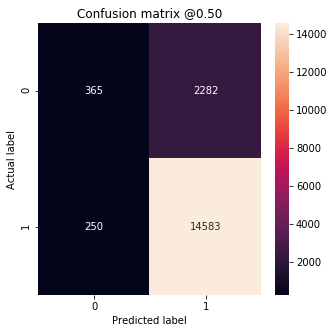

In [59]:
# CM for cv
y_pred = model.predict([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num])
plot_cm(cv_y, y_pred)

(True Negatives):  446
(False Positives):  2862
(False Negatives):  328
(True Positives):  18214
Total:  18542


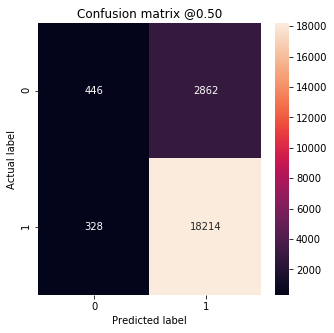

In [60]:
# CM for test
y_pred = model.predict([ts_essay, ts_sch_st, ts_proj_gr, ts_proj_cat, ts_proj_subcat, ts_teacher_prf, ts_3num])
plot_cm(ts_y, y_pred)

<table>
    <tr>
        <td colspan=3 style="text-align: center"><strong>Model Training Overview Architecture</strong><td>
    </tr>
    <tr>
        <td colspan=3><img src='model_1_arc.PNG' width=900px/>
    </tr>
    <tr>
       <td style="text-align: center"><strong>Training accuracy</strong></td>\
       <td style="text-align: center"><strong>Training loss</strong></td>
       <td style="text-align: center"><strong>Training auroc</strong></td>
    </tr>
    <tr>
        <td><img src='train_acc_1.PNG' width=300px /></td>
        <td><img src='train_loss_1.PNG' width=300px /></td>
        <td><img src='train_roc_1.PNG' width=300px /></td>
    </tr>
    <tr>
       <td style="text-align: center"><strong>CV accuracy</strong></td>\
       <td style="text-align: center"><strong>CV loss</strong></td>
       <td style="text-align: center"><strong>CV auroc</strong></td>
    </tr>
    <tr>
        <td><img src='val_acc_1.PNG' width=300px /></td>
        <td><img src='val_loss_1.PNG' width=300px /></td>
        <td><img src='val_roc_1.PNG' width=300px /></td>
     </tr>
</table>

>Note: Dont worry about overfitting in this graph, we put the earlycallback parameter with patience=10 and restore_best_weights=True. So its will store the weights of best one only. best one means with highest val_auroc score

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
vec = TfidfVectorizer()
vec.fit(tr_X['clean_essay'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [11]:
# Number of words = number of idf value generated corresponding word
idf_value = vec.idf_
max_idf_value = max(vec.idf_)
min_idf_value = min(vec.idf_)
print('Shape of idf value', vec.idf_.shape)
print('Max idf value:',max_idf_value,', Min idf value:',min_idf_value)

Shape of idf value (47252,)
Max idf value: 11.4619455276077 , Min idf value: 1.0076667233625343


In [12]:
vocab = vec.vocabulary_
print('Number of words present:',len(vocab))

Number of words present: 47252


__(Just to make use idf_ and vocabulary contain same number of words)__

Analysis of IDF value in Essay

In [13]:
word_idf = {}
for word in vocab.keys():
    word_idf[word] = idf_value[vocab.get(word)] 

In [14]:
len(word_idf)

47252

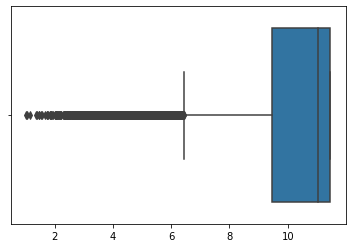

In [15]:
sns.boxplot(vec.idf_)
plt.show()

> lower idf = 6 and upper idf value = 11

In [16]:
lower_idf = 6
upper_idf = 11

for word in vocab.keys():
    if word_idf[word] > lower_idf and word_idf[word] < upper_idf:
        word_idf.pop(word)

In [17]:
len(word_idf)

25884

In [18]:
# Maximum length of each essay in overall train data
X = tr_X['clean_essay'].values
max_ = 0
for i in range(X.shape[0]):
    if max_ < len(X[i].split()):
        max_ = len(X[i].split())
max_

312

In [19]:
vec = Tokenizer()
vec.fit_on_texts(tr_X['clean_essay'].values)

In [20]:
# length of vocabuary size
vocab_size = len(vec.word_index)+1
vocab_size

47281

In [21]:
# Store word to idx value
char_to_idx = vec.word_index

In [22]:
temp = list(char_to_idx.keys())
for i in temp:
    if i not in word_idf:
        char_to_idx.pop(i)
        
len(char_to_idx)

25884

In [23]:
# Now since some words are remove, so their corresponding index also removed
# SO let assign their index value sequentially

index = 0
for i in char_to_idx.keys():
    char_to_idx[i] = index
    index += 1

In [24]:
vocab_size = len(char_to_idx)
vocab_size

25884

In [27]:
# Convert each sentence of train too idx value
tr_essay = sent_to_idx(tr_X,'clean_essay',char_to_idx)
# Convert each sentence of test too idx value
ts_essay = sent_to_idx(ts_X,'clean_essay',char_to_idx)
# Convert each sentence of cv too idx value
cv_essay = sent_to_idx(cv_X,'clean_essay',char_to_idx)

tr_essay = pad_sequences(tr_essay, maxlen=max_)
ts_essay = pad_sequences(ts_essay, maxlen=max_)
cv_essay = pad_sequences(cv_essay, maxlen=max_)
tr_essay.shape, ts_essay.shape, cv_essay.shape, vocab_size

((69918, 312), (21850, 312), (17480, 312), 25884)

In [28]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model1 = pickle.load(f)
    glove_words =  set(model1.keys())

In [29]:
#Creating a matrix with rows as words and columns with 50 dim vectors for each word
def weight_essay_mat(word_index, embedding_dim = 300):
    weight_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        if word in glove_words:
            weight_matrix[i] = model1[word]
    return weight_matrix

In [30]:
weight_essay_mat(char_to_idx).shape

(25884, 300)

**Run all the cell except essay subcell part**

# Model Architecture
same as Model 1

In [31]:
%load_ext tensorboard

In [32]:
logdir = os.path.join('logs_1\model_2')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000)

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auroc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [50]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
tf.keras.backend.clear_session()

def model_2():
        
    # Text layer (69918, 312)
    input_layer_1 = Input(shape=(312,), name='input_seq_total_text_data')
    embedding_1 = Embedding(vocab_size, 300, input_length= 312, weights=[weight_essay_mat(char_to_idx)],name='Emb_Text_Data',\
                           trainable=False)(input_layer_1)
    lstm_1 = LSTM(100, return_sequences=True, name='lstm_1')(embedding_1)
    drp_1 = Dropout(0.5)(lstm_1)
    flatten_1 = Flatten()(drp_1)

    # School state layer (69918, )
    input_layer_2 = Input(shape=(1,), name='input_school_state')
    embedding_2 = Embedding(input_dim=school_size, output_dim=int(np.ceil(school_size/2)), name='Emb_State_Data')(input_layer_2)
    flatten_2 = Flatten()(embedding_2)

    # Project Grade Category layer (69918, 1)
    input_layer_3 = Input(shape=(1,), name='project_grade_category')
    embedding_3 = Embedding(input_dim=grade_size, output_dim=int(np.ceil(grade_size/2)), name='Emb_PGC_Data')(input_layer_3)
    flatten_3 = Flatten()(embedding_3)

    # Project Subject category (69918, 1)
    input_layer_4 = Input(shape=(1,), name='input_clean_categories')
    embedding_4 = Embedding(input_dim=cat_size, output_dim=int(np.ceil(cat_size/2)), name='Emb_clean_categories_Data')(input_layer_4)
    flatten_4 = Flatten()(embedding_4)

    # Project subject subcategory (69918, 31)
    input_layer_5 = Input(shape=(1,), name='input_clean_subcategories')
    embedding_5 = Embedding(input_dim=subcat_size, output_dim=int(np.ceil(subcat_size/2)), name='Emb_clean_subcategories_Data')(input_layer_5)
    flatten_5 = Flatten()(embedding_5)

    # teacher prefix (69918, 1)
    input_layer_6 = Input(shape=(1,), name='input_teacher_prefix')
    embedding_6 = Embedding(input_dim=teacher_prf_size, output_dim=int(np.ceil(teacher_prf_size/2)), name='Emb_teacher_prefix_Data')(input_layer_6)
    flatten_6 = Flatten()(embedding_6)

    # 3 num feat (69918, 3)
    input_layer_7 = Input(shape=(3,), name='input_3num_feat')
    dense_7 = Dense(8, activation='relu', name='Dense_3numfeat_Data', kernel_initializer='glorot_normal')(input_layer_7)
    flatten_7 = Flatten()(dense_7) 

    # Concat layer
    concat_layer = concatenate(inputs=[flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, flatten_7], \
                               name='concatenate')

    # Dense Layer and Dropout
    dense_8 = Dense(64, activation='relu', name='Dense_layer1_after_concat', \
                    kernel_initializer='glorot_normal')(concat_layer)
    drp_8 = Dropout(0.5)(dense_8)

    dense_9 = Dense(32, activation='relu', name='Dense_layer2_after_concat', \
                            kernel_initializer='glorot_normal')(drp_8)
    drp_9 = Dropout(0.5)(dense_9)

    dense_10 = Dense(16, activation='relu', name='Dense_layer3_after_concat', \
                     kernel_initializer='glorot_normal')(drp_9)

    output_layer = Dense(1, activation='sigmoid')(dense_10)

    # model = Model(inputs=input_layer_1, outputs=output_layer)
    model = Model(inputs=[input_layer_1, input_layer_2, input_layer_3, input_layer_4, \
                          input_layer_5, input_layer_6, input_layer_7], outputs=output_layer)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc])
    
    return model

In [51]:
model = model_2()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 312)]        0                                            
__________________________________________________________________________________________________
Emb_Text_Data (Embedding)       (None, 312, 300)     7765200     input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 312, 100)     160400  

In [52]:
model.fit(
[tr_essay, tr_sch_st, tr_proj_gr, tr_proj_cat, tr_proj_subcat, tr_teacher_prf, tr_3num], tr_y, batch_size=256, epochs=100, \
    validation_data=([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num], cv_y), \
    callbacks=[early_stopping, tensorboard_callback], verbose=1)

Train on 69918 samples, validate on 17480 samples
Epoch 1/100
69918/69918 [==============================] - 136s 2ms/sample - loss: 0.4471 - acc: 0.8394 - auroc: 0.5956 - val_loss: 0.4135 - val_acc: 0.8486 - val_auroc: 0.7109
Epoch 2/100
69918/69918 [==============================] - 133s 2ms/sample - loss: 0.3958 - acc: 0.8489 - auroc: 0.7015 - val_loss: 0.4001 - val_acc: 0.8496 - val_auroc: 0.7282
Epoch 3/100
69918/69918 [==============================] - 133s 2ms/sample - loss: 0.3827 - acc: 0.8500 - auroc: 0.7300 - val_loss: 0.3851 - val_acc: 0.8509 - val_auroc: 0.7352
Epoch 4/100
69918/69918 [==============================] - 132s 2ms/sample - loss: 0.3716 - acc: 0.8533 - auroc: 0.7497 - val_loss: 0.3840 - val_acc: 0.8521 - val_auroc: 0.7364
Epoch 5/100
69918/69918 [==============================] - 132s 2ms/sample - loss: 0.3596 - acc: 0.8564 - auroc: 0.7742 - val_loss: 0.3787 - val_acc: 0.8526 - val_auroc: 0.7301
Epoch 6/100
69918/69918 [==============================] - 130s 2

In [53]:
# Eval score on train
l,a,au = model.evaluate([tr_essay, tr_sch_st, tr_proj_gr, tr_proj_cat, tr_proj_subcat, tr_teacher_prf, tr_3num], \
                        tr_y, batch_size=256)
print('Train Loss: {}, Train Acc.: {}, Train AUROC: {}'.format(l,a,au))

69918/69918 [==============================] - 53s 759us/sample - loss: 0.3611 - acc: 0.8599 - auroc: 0.8030 - loss: 0.3601 - acc
Train Loss: 0.3611426201957959, Train Acc.: 0.8598787188529968, Train AUROC: 0.8029965758323669


In [54]:
# Eval score on cv
l,a,au = model.evaluate([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num], cv_y, \
                        batch_size=256)
print('CV Loss: {}, CV Acc.: {}, CV AUROC: {}'.format(l,a,au))

17480/17480 [==============================] - 13s 769us/sample - loss: 0.3840 - acc: 0.8521 - auroc: 0.7351
CV Loss: 0.3840115178913492, CV Acc.: 0.8521167039871216, CV AUROC: 0.7350538372993469


In [55]:
# Eval score on test
l,a,au = model.evaluate([ts_essay, ts_sch_st, ts_proj_gr, ts_proj_cat, ts_proj_subcat, ts_teacher_prf, ts_3num], ts_y, \
                        batch_size=256)
print('Test Loss: {}, Test Acc.: {}, Test AUROC: {}'.format(l,a,au))

21850/21850 [==============================] - 17s 763us/sample - loss: 0.3830 - acc: 0.8519 - auroc: 0.7401
Test Loss: 0.3829996793493799, Test Acc.: 0.8519451022148132, Test AUROC: 0.7401143908500671


(True Negatives):  177
(False Positives):  2470
(False Negatives):  115
(True Positives):  14718
Total:  14833


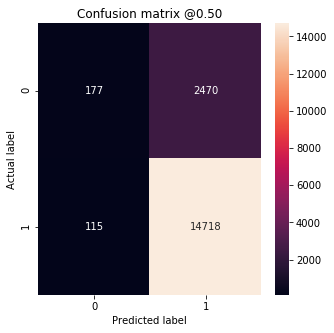

In [57]:
# CM for cv
y_pred = model.predict([cv_essay, cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_3num])
plot_cm(cv_y, y_pred)

(True Negatives):  235
(False Positives):  3073
(False Negatives):  162
(True Positives):  18380
Total:  18542


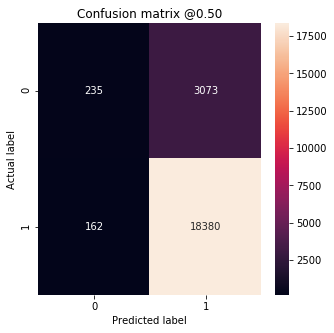

In [58]:
# CM for test
y_pred = model.predict([ts_essay, ts_sch_st, ts_proj_gr, ts_proj_cat, ts_proj_subcat, ts_teacher_prf, ts_3num])
plot_cm(ts_y, y_pred)

<table>
    <tr>
        <td colspan=3 style="text-align: center"><strong>Model Training Overview Architecture</strong><td>
    </tr>
    <tr>
        <td colspan=3><img src='model_2_arc.PNG' width=900px/>
    </tr>
    <tr>
       <td style="text-align: center"><strong>Training accuracy</strong></td>\
       <td style="text-align: center"><strong>Training loss</strong></td>
       <td style="text-align: center"><strong>Training auroc</strong></td>
    </tr>
    <tr>
        <td><img src='train_acc_2.PNG' width=300px /></td>
        <td><img src='train_loss_2.PNG' width=300px /></td>
        <td><img src='train_roc_2.PNG' width=300px /></td>
    </tr>
    <tr>
       <td style="text-align: center"><strong>CV accuracy</strong></td>\
       <td style="text-align: center"><strong>CV loss</strong></td>
       <td style="text-align: center"><strong>CV auroc</strong></td>
    </tr>
    <tr>
        <td><img src='val_acc_2.PNG' width=300px /></td>
        <td><img src='val_loss_2.PNG' width=300px /></td>
        <td><img src='val_roc_2.PNG' width=300px /></td>
     </tr>
</table>

>Note: Dont worry about overfitting in this graph, we put the earlycallback parameter with patience=10 and restore_best_weights=True. So its will store the weights of best one only. best one means with highest val_auroc score

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [25]:
from scipy.sparse import hstack
import matplotlib.pyplot as plt

In [16]:
# School State
vec = OneHotEncoder(handle_unknown='ignore')
tr_sch_st = vec.fit_transform(tr_X['school_state'].values.reshape(-1,1))
ts_sch_st = vec.transform(ts_X['school_state'].values.reshape(-1,1))
cv_sch_st = vec.transform(cv_X['school_state'].values.reshape(-1,1))
school_size = len(vec.categories_[0])
tr_sch_st.shape, ts_sch_st.shape, cv_sch_st.shape, school_size

((69918, 51), (21850, 51), (17480, 51), 51)

In [17]:
# Project State
vec = OneHotEncoder(handle_unknown='ignore')
tr_proj_gr = vec.fit_transform(tr_X['project_grade_category'].values.reshape(-1,1))
ts_proj_gr = vec.transform(ts_X['project_grade_category'].values.reshape(-1,1))
cv_proj_gr = vec.transform(cv_X['project_grade_category'].values.reshape(-1,1))
grade_size = len(vec.categories_[0])
tr_proj_gr.shape, ts_proj_gr.shape, cv_proj_gr.shape, grade_size

((69918, 4), (21850, 4), (17480, 4), 4)

In [18]:
# Project Subject Categories
vec = OneHotEncoder(handle_unknown='ignore')
tr_proj_cat = vec.fit_transform(tr_X['project_subject_categories'].values.reshape(-1,1))
ts_proj_cat = vec.transform(ts_X['project_subject_categories'].values.reshape(-1,1))
cv_proj_cat = vec.transform(cv_X['project_subject_categories'].values.reshape(-1,1))
cat_size = len(vec.categories_[0])
tr_proj_cat.shape, ts_proj_cat.shape, cv_proj_cat.shape, cat_size

((69918, 51), (21850, 51), (17480, 51), 51)

In [19]:
# Project Subject SubCategories
vec = OneHotEncoder(handle_unknown='ignore')
tr_proj_subcat = vec.fit_transform(tr_X['project_subject_subcategories'].values.reshape(-1,1))
ts_proj_subcat = vec.transform(ts_X['project_subject_subcategories'].values.reshape(-1,1))
cv_proj_subcat = vec.transform(cv_X['project_subject_subcategories'].values.reshape(-1,1))
subcat_size = len(vec.categories_[0])
tr_proj_subcat.shape, ts_proj_subcat.shape, cv_proj_subcat.shape, subcat_size

((69918, 393), (21850, 393), (17480, 393), 393)

In [20]:
# Teacher Prefix
vec = OneHotEncoder(handle_unknown='ignore')
tr_teacher_prf = vec.fit_transform(tr_X['teacher_prefix'].values.reshape(-1,1))
ts_teacher_prf = vec.transform(ts_X['teacher_prefix'].values.reshape(-1,1))
cv_teacher_prf = vec.transform(cv_X['teacher_prefix'].values.reshape(-1,1))
teacher_prf_size = len(vec.categories_[0])
tr_teacher_prf.shape, ts_teacher_prf.shape, cv_teacher_prf.shape, teacher_prf_size

((69918, 5), (21850, 5), (17480, 5), 5)

For numerical feature , already defined in before model_1. Go and compile 3 numerical only

# Merge above features

In [25]:
tr_essay.shape, tr_sch_st.shape, tr_proj_gr.shape, tr_proj_cat.shape, tr_proj_subcat.shape, tr_teacher_prf.shape, tr_teacherprev_norm.shape, \
                    tr_price.shape, tr_quant.shape

((69918, 312),
 (69918, 51),
 (69918, 4),
 (69918, 51),
 (69918, 393),
 (69918, 5),
 (69918, 1),
 (69918, 1),
 (69918, 1))

In [46]:
# Everything beforehand was some text, so we converted into numerical feature
tr_other = hstack((tr_sch_st, tr_proj_gr, tr_proj_cat, tr_proj_subcat, tr_teacher_prf, tr_teacherprev_norm, \
                    tr_price, tr_quant))

In [47]:
tr_other = tr_other.toarray()
tr_other.shape

(69918, 507)

In [48]:
# Everything beforehand was some text, so we converted into numerical feature
ts_other = hstack((ts_sch_st, ts_proj_gr, ts_proj_cat, ts_proj_subcat, ts_teacher_prf, ts_teacherprev_norm, \
                    ts_price, ts_quant))

ts_other = ts_other.toarray()
ts_other.shape

(21850, 507)

In [49]:
# Everything beforehand was some text, so we converted into numerical feature
cv_other = hstack((cv_sch_st, cv_proj_gr, cv_proj_cat, cv_proj_subcat, cv_teacher_prf, cv_teacherprev_norm, \
                    cv_price, cv_quant))

cv_other = cv_other.toarray()
cv_other.shape

(17480, 507)

In [31]:
weight_essay_mat(char_to_idx).shape, essay_size

((47281, 300), 47281)

# Model Architecture

In [32]:
%load_ext tensorboard

In [33]:
logdir = os.path.join('logs_1\model_3')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000)

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auroc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [42]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
tf.keras.backend.clear_session()

def model_3():
        
    # Text layer ((118662, 312)
    input_layer_1 = Input(shape=(312,), name='input_seq_total_text_data')
    embedding_1 = Embedding(essay_size, 300, input_length= 312, weights=[weight_essay_mat(char_to_idx)],name='Emb_Text_Data',\
                           trainable=False)(input_layer_1)
    lstm_1 = LSTM(256, name='lstm_1', return_sequences=True)(embedding_1)
    drp_1 = Dropout(0.5)(lstm_1)
    flatten_1 = Flatten()(drp_1)

    # Other text feat (118662, 507)
    input_layer_2 = Input(shape=(507,1), name='input_3num_feat')
    res = Reshape((507,1))(input_layer_2)
    conv1_2 = Conv1D(16, 3, kernel_initializer='glorot_normal', activation='relu', input_shape=(507,1))(input_layer_2)
    max1_2 = MaxPool1D(2)(conv1_2)
    drp1 = Dropout(0.5)(max1_2)
    conv2_2 = Conv1D(8, 3, kernel_initializer='glorot_normal', activation='relu')(drp1)
    max2_2 = MaxPool1D(2)(conv2_2)
    drp2 = Dropout(0.5)(max2_2)
    conv3_2 = Conv1D(4, 1, kernel_initializer='glorot_normal', activation='relu')(drp1)
    max3_2 = MaxPool1D(2)(conv3_2)
    drp3 = Dropout(0.5)(max3_2)
    flatten_2 = Flatten()(drp3) 

    # Concat layer
    concat_layer = concatenate(inputs=[flatten_1, flatten_2], name='concatenate')

    # Dense Layer and Dropout
    dense_8 = Dense(64, activation='relu', name='Dense_layer1_after_concat', \
                    kernel_initializer='glorot_normal')(concat_layer)
    drp_8 = Dropout(0.5)(dense_8)

    dense_9 = Dense(32, activation='relu', name='Dense_layer2_after_concat', \
                            kernel_initializer='glorot_normal')(drp_8)
    drp_9 = Dropout(0.5)(dense_9)

    dense_10 = Dense(16, activation='relu', name='Dense_layer3_after_concat', \
                     kernel_initializer='glorot_normal')(drp_9)

    output_layer = Dense(1, activation='sigmoid')(dense_10)

    # model = Model(inputs=input_layer_1, outputs=output_layer)
    model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc])
    
    return model

In [51]:
model = model_3()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3num_feat (InputLayer)    [(None, 507, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 505, 16)      64          input_3num_feat[0][0]            
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 252, 16)      0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
input_seq_total_text_data (Inpu [(None, 312)]        0                                            
____________________________________________________________________________________________

In [52]:
# tr_other = tr_other[:, :, np.newaxis]
# cv_other = cv_other[:, :, np.newaxis]
model.fit([tr_essay, tr_other], tr_y, batch_size=300, epochs=100, validation_data=([cv_essay, cv_other], cv_y), \
          callbacks=[early_stopping, tensorboard_callback], verbose=1)

Train on 69918 samples, validate on 17480 samples
Epoch 1/100
69918/69918 [==============================] - 227s 3ms/sample - loss: 0.4343 - acc: 0.8451 - auroc: 0.6310 - val_loss: 0.4464 - val_acc: 0.8486 - val_auroc: 0.7065
Epoch 2/100
69918/69918 [==============================] - 227s 3ms/sample - loss: 0.3952 - acc: 0.8490 - auroc: 0.7055 - val_loss: 0.4385 - val_acc: 0.8486 - val_auroc: 0.7282
Epoch 3/100
69918/69918 [==============================] - 228s 3ms/sample - loss: 0.3811 - acc: 0.8497 - auroc: 0.7364 - val_loss: 0.4221 - val_acc: 0.8484 - val_auroc: 0.7269
Epoch 4/100
69918/69918 [==============================] - 227s 3ms/sample - loss: 0.3681 - acc: 0.8505 - auroc: 0.7654 - val_loss: 0.4179 - val_acc: 0.8508 - val_auroc: 0.7222
Epoch 5/100
69918/69918 [==============================] - 224s 3ms/sample - loss: 0.3520 - acc: 0.8548 - auroc: 0.7944 - val_loss: 0.4092 - val_acc: 0.8525 - val_auroc: 0.7208
Epoch 6/100
69918/69918 [==============================] - 225s 3

In [54]:
# Eval score on train
l,a,au = model.evaluate([tr_essay, tr_other], tr_y, batch_size=300)
print('Train Loss: {}, Train Acc.: {}, Train AUROC: {}'.format(l,a,au))

69918/69918 [==============================] - 74s 1ms/sample - loss: 0.4324 - acc: 0.8486 - auroc: 0.7623
Train Loss: 0.43238280363566967, Train Acc.: 0.8486369848251343, Train AUROC: 0.7623317837715149


In [55]:
# Eval score on cv
l,a,au = model.evaluate([cv_essay, cv_other], cv_y, batch_size=300)
print('CV Loss: {}, CV Acc.: {}, CV AUROC: {}'.format(l,a,au))

17480/17480 [==============================] - 19s 1ms/sample - loss: 0.4385 - acc: 0.8486 - auroc: 0.7300
CV Loss: 0.43853438940555606, CV Acc.: 0.8485698103904724, CV AUROC: 0.7300376296043396


In [56]:
# Eval score on test
ts_other = ts_other[:, :, np.newaxis]
l,a,au = model.evaluate([ts_essay, ts_other], ts_y, batch_size=300)
print('Test Loss: {}, Test Acc.: {}, Test AUROC: {}'.format(l,a,au))

21850/21850 [==============================] - 23s 1ms/sample - loss: 0.4390 - acc: 0.8486 - auroc: 0.7273
Test Loss: 0.4389937845329398, Test Acc.: 0.8486498594284058, Test AUROC: 0.7273017168045044


(True Negatives):  1
(False Positives):  2646
(False Negatives):  1
(True Positives):  14832
Total:  14833


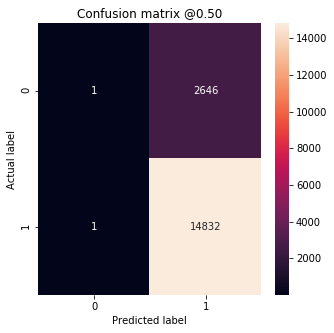

In [58]:
# CM for cv
y_pred = model.predict([cv_essay, cv_other])

plot_cm(cv_y, y_pred)

(True Negatives):  1
(False Positives):  3307
(False Negatives):  0
(True Positives):  18542
Total:  18542


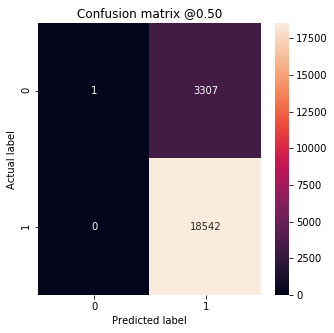

In [59]:
# CM for test
y_pred = model.predict([ts_essay, ts_other])

plot_cm(ts_y, y_pred)

<table>
    <tr>
        <td colspan=3 style="text-align: center"><strong>Model Training Overview Architecture</strong><td>
    </tr>
    <tr>
        <td colspan=3><img src='model_3_arc.PNG' width=900px/>
    </tr>
    <tr>
       <td style="text-align: center"><strong>Training accuracy</strong></td>\
       <td style="text-align: center"><strong>Training loss</strong></td>
       <td style="text-align: center"><strong>Training auroc</strong></td>
    </tr>
    <tr>
        <td><img src='train_acc_3.PNG' width=300px /></td>
        <td><img src='train_loss_3.PNG' width=300px /></td>
        <td><img src='train_roc_3.PNG' width=300px /></td>
    </tr>
    <tr>
       <td style="text-align: center"><strong>CV accuracy</strong></td>\
       <td style="text-align: center"><strong>CV loss</strong></td>
       <td style="text-align: center"><strong>CV auroc</strong></td>
    </tr>
    <tr>
        <td><img src='val_acc_3.PNG' width=300px /></td>
        <td><img src='val_loss_3.PNG' width=300px /></td>
        <td><img src='val_roc_3.PNG' width=300px /></td>
     </tr>
</table>

>Note: Dont worry about overfitting in this graph, we put the earlycallback parameter with patience=10 and restore_best_weights=True. So its will store the weights of best one only. best one means with highest val_auroc score

# Conclusion

In [60]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Train AUROC','CV AUROC','Test AUROC']
x.add_row(['Model 1',0.8119340538978577,0.7508285045623779,0.7544023394584656])
x.add_row(['Model 2',0.8029965758323669,0.7350538372993469,0.7401143908500671])
x.add_row(['Model 3',0.7623317837715149,0.7300376296043396,0.7273017168045044])

print(x)

+---------+--------------------+--------------------+--------------------+
|  Model  |    Train AUROC     |      CV AUROC      |     Test AUROC     |
+---------+--------------------+--------------------+--------------------+
| Model 1 | 0.8119340538978577 | 0.7508285045623779 | 0.7544023394584656 |
| Model 2 | 0.8029965758323669 | 0.7350538372993469 | 0.7401143908500671 |
| Model 3 | 0.7623317837715149 | 0.7300376296043396 | 0.7273017168045044 |
+---------+--------------------+--------------------+--------------------+
